# Motivation

The most basic form of learning, through associations between stimulus and reward, can be observed across many species and happens to be one of the most important tools of behavioral modifications. *Rescorla-Wagner model* has been an important development to understand how learning is affected by every presentation of stimulus-reward. While the model predicts two important principles of associative learning -- reward prediction errors drive learning and simultaneously presented stimuli summate to predict reward -- it however ignores uncertainty about weights (or associative strengths) which have been shown to play an important role in human learning. This issue can be resolved by the *Kalman filter*, which postulates a Bayesian view of learning and incorporates uncertainty into the learning paradigm. Kalman filter still cannot resolve a fundamental issue with the Rescorla-Wagner Model: It is a trial-level model, making predictions only at the level of each trial and thereby ignoring the intra-trial structure such as stimulus duration and inter-stimulus interval, deemphasizing on long-term learning and prediction. On the contrary, the *Temporal Difference models* of associative learning focus on long term reward prediction and learning. TD models perform wonderfully in conditions where Rescorla-Wagner cannot: accounting for effect of intra-trial phenomenon, but it lacks the uncertainty tracking mechanism of the Kalman Filter. Samuel J. Gershman provided a 'Unifying View of Associative Learning' (cite:Gershman2015) through *Kalman Temporal Difference* (cite:geist2010-kalmantd), by integrating various aspects of different associative models.

In this project, we provide a python implementation for KalmanTD, along with code for running various paradigms mentioned in (cite:Gershman2015).


# Kalman Temporal Difference

The code for KalmanTD found in [[file:KalmanTD.py]] is given below. This consists of the main class =KalmanTD= and functions/methods =predict_reward= and =update=. A function =default_kalman_td= is provided as a helper function.


In [1]:
# Implementation based on Gershman (2015)
#   "A Unifying Probabilistic View of Associative Learning"
# and Algorithm 1 from Geist and Pietquin (2010)
#   "Kalman Temporal Differences"

from numpy import *

# Keep methods separate from classes with Julia and Common Lisp style.
# Aids rapid prototyping while using emacs integrated REPL, since we
# do not need to reconstructKalmanTD instances.
class KalmanTD:
    # We are assuming num_reward_features = 1, otherwise calculation
    # for the Kalman Gain in the update function below do not seem to
    # make sense in terms of matrix dimensions
    def __init__(self, num_stimulus_features, tau, gamma, sigma_w, sigma_r):
        """
        tau     : (tau^2 * I) is added to the weights_cov at every time step
        gamma   : used to compute discounted_time_derivative
                  stimulus_features_old - gamma * stimulus_features_new
        sigma_w : initially, weights_cov = sigma_w^2 * identity_matrix
        sigma_r : actual_reward ~ normal(expected_noise, sigma_r)
        """
        self.weights_mean = zeros((num_stimulus_features, 1))
        self.num_weights  = num_stimulus_features
        self.weights_cov  = sigma_w**2 * identity(self.num_weights)
        self.tau          = tau
        self.weights_cov_noise = tau**2 * identity(self.num_weights)
        self.gamma = gamma
        self.sigma_w      = sigma_w
        self.sigma_r      = sigma_r
        self.old_kalman_gain  = None

def _compute_discounted_time_derivative(
        ktd:KalmanTD, stimulus_features_new, stimulus_features_old
):
    # Ht = Xt-Gamma*(Xt+1) : Correction Paper
    return stimulus_features_old - ktd.gamma * stimulus_features_new

def predict_reward(ktd:KalmanTD, stimulus_features_new, stimulus_features_old):
    # First compute discounted time derivative (h_t in the paper)
    discounted_time_derivative = _compute_discounted_time_derivative(
        ktd, stimulus_features_new, stimulus_features_old
    )

    # Then, check for correct dimensionality
    Ns1, _ = ktd.weights_mean.shape
    Ns2, _ = discounted_time_derivative.shape
    assert Ns1 == Ns2, \
        "Weights and stimulus are of incompatible shape: " + \
        "weights {0}, stimulus {1}".format(
            ktd.weights_mean.shape, discounted_time_derivative.shape
        )

    # Update the mean and covariance
    ktd.weights_mean = ktd.weights_mean # mean remains the same
    ktd.weights_cov  += ktd.weights_cov_noise

    # Algorithm 1 from Geist and Pietquin suggests that the predicted reward
    # is the expected reward over the weights
    return (ktd.weights_mean.T @ discounted_time_derivative).flat[0]

def update(
        ktd:KalmanTD,
        expected_reward,
        actual_reward,
        stimulus_features_new,
        stimulus_features_old
):
    """
    Update the weights, given the actual reward. We are taking
    expected_reward as an argument, because the weights_cov change in
    the mere process of calculating it.
    """

    discounted_time_derivative = _compute_discounted_time_derivative(
        ktd, stimulus_features_new, stimulus_features_old
    )
    delta = actual_reward - expected_reward

    # numer: vector of dimensions (num_stimulus_features, 1)
    numer = ktd.weights_cov @ discounted_time_derivative
    # denom: scalar
    denom = (discounted_time_derivative.T @ ktd.weights_cov \
             @ discounted_time_derivative).flat[0] \
             + ktd.sigma_r**2
    kalman_gain = numer / denom

    ktd.weights_mean += kalman_gain * delta
    ktd.weights_cov  -= kalman_gain @ discounted_time_derivative.T @ ktd.weights_cov
    # current kalman gain can only be computed after a round of predict
    ktd.old_kalman_gain = kalman_gain

    return

def default_kalman_td(num_stimulus_features):
    return KalmanTD(
        num_stimulus_features,
        tau=0.1,
        gamma=0.98,
        sigma_r=1,
        sigma_w=1
    )

# Simulations

All the simulations below assume the following header:



In [2]:
from KalmanTD import *
import numpy as np
import matplotlib.pyplot as plt

The parameters used for all the simulations are from cite:Gershman2015 and are given below:

<center>$\displaystyle \sigma_w^2 = 1, \sigma_r^2 = 1, \tau^2 = 0.01, \gamma = 0.98$</center>

In the following subsections, we provide a brief description of each of the paradigms, along with the associated plots. The code corresponding to each of the simulations has been provided in [[file:simulations.ipynb]].

The basic structure of simulations is to create a 3D array representing stimuli, and a 2D array representing the rewards. The first dimension for each of these is the time axis, thus each 2D sub-array along the outer dimension denotes a stimuli at a particular time step. This sub-array is actually a one-hot-encoded column vector, with first dimension denoting the various stimuli present in the paradigm, and the second dimension equal to 1. In a similar manner, the second dimension for the reward array is equal to 1.

Once the stimuli and rewards are created, one alternately calls =predict_reward= and =update= with the appropriate =KalmanTD= instance, tracking various variables (variance, covariance, kalman gain) one needs to track, and optionally presenting the test stimuli to obtain the expected reward.



## Latent Inhibition

([0.0,
  0.08981151567787574,
  0.16230669085326682,
  0.22113147019752993,
  0.2690326084494179,
  0.3081318742342091,
  0.34009828456498514,
  0.36626178329512404,
  0.387691769169549,
  0.4052535614536078],
 [0.0,
  0.3367443378706777,
  0.4045915517489047,
  0.4333604348151817,
  0.4490485653238766,
  0.45878249955401834,
  0.46531137439706544,
  0.46992127344906653,
  0.473294790022397,
  0.47582823375146543])

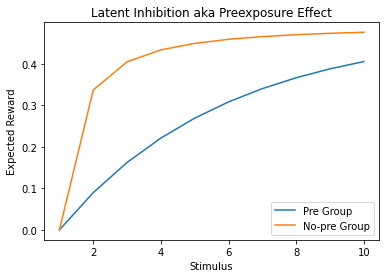

In [3]:
def simulate_latent_inhibition():

    control_ktd         = default_kalman_td(1)
    experimental_ktd = default_kalman_td(1)
    preex_stimulus = [np.array([[0]]), np.array([[1]])] * 10
    preex_reward   = [np.array([[0]]), np.array([[0]])] * 10

    for i in range(1,20):
        expected_reward = predict_reward(
            experimental_ktd,
            preex_stimulus[i],
            preex_stimulus[i-1]
        )
        update(
            experimental_ktd,
            expected_reward,
            preex_reward[i],
            preex_stimulus[i],
            preex_stimulus[i-1]
        )

    exp_stimulus = [np.array([[1]]), np.array([[0]])] * 10
    exp_reward     = [np.array([[0]]), np.array([[1]])] * 10

    exp_expected_rewards, ctrl_expected_rewards = [], []

    for i in range(1,20):
        exp_expected_reward = predict_reward(
            experimental_ktd,
            exp_stimulus[i],
            exp_stimulus[i-1]
        )
        update(
            experimental_ktd,
            exp_expected_reward,
            exp_reward[i],
            exp_stimulus[i],
            exp_stimulus[i-1]
        )

        ctrl_expected_reward = predict_reward(
            control_ktd,
            exp_stimulus[i],
            exp_stimulus[i-1]
        )
        update(
            control_ktd,
            ctrl_expected_reward,
            exp_reward[i],
            exp_stimulus[i],
            exp_stimulus[i-1]
        )

        if exp_stimulus[i-1] != 0:
            exp_expected_rewards.append(exp_expected_reward)
            ctrl_expected_rewards.append(ctrl_expected_reward)

    plt.clf()
    plt.plot(arange(1,11), exp_expected_rewards, label="Pre Group")
    plt.plot(arange(1,11), ctrl_expected_rewards, label="No-pre Group")
    plt.title("Latent Inhibition aka Preexposure Effect")
    plt.xlabel("Stimulus")
    plt.ylabel("Expected Reward")
    plt.legend()
    plt.savefig("plots/latent_inhibition.svg")

    return exp_expected_rewards, ctrl_expected_rewards

simulate_latent_inhibition()

## Overshadowing

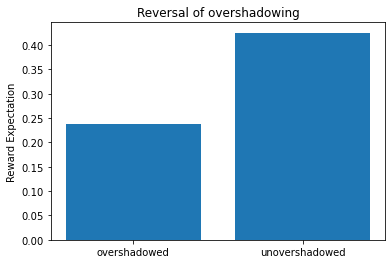

In [4]:
def simulate_overshadowing_and_unovershadowing():
    control_ktd = default_kalman_td(2)
    experimental_ktd = default_kalman_td(2)

    # A -> -;
    pre_stimulus = np.tile(np.array([[[1],[0]],[[0],[0]]]),[10,1,1])
    pre_reward = np.tile(np.array([[0],[0]]),[10,1])

    for i in range(1,len(pre_reward)-2,2):
        for j in range(i, i+1):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                pre_stimulus[j],
                pre_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                pre_reward[j],
                pre_stimulus[j],
                pre_stimulus[j-1]
            )

    # AB -> +
    p1_stimulus = np.tile(np.array([[[1],[1]],[[0],[0]]]),[10,1,1])
    p1_reward = np.tile(np.array([[0],[1]]),[10,1])

    for i in range(1,len(p1_reward)-2,2):
        for j in range(i, i+2):
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )

    # B -> ?
    test_stimulus = np.array([[[0],[1]],[[0],[0]]])
    ctrl_test_reward = predict_reward(control_ktd,test_stimulus[1],test_stimulus[0])
    exp_test_reward = predict_reward(experimental_ktd,test_stimulus[1],test_stimulus[0])

    plt.clf()
    barplot = plt.bar([1,2], [ctrl_test_reward, exp_test_reward])
    plt.xticks([1,2], ["overshadowed", "unovershadowed"])
    plt.ylabel("Reward Expectation")
    plt.title("Reversal of overshadowing")
    plt.savefig("plots/overshadowing_unovershadowing.svg")

    return

simulate_overshadowing_and_unovershadowing()

## Forward Blocking

(0.02571879783074959, 0.2545982267269431)

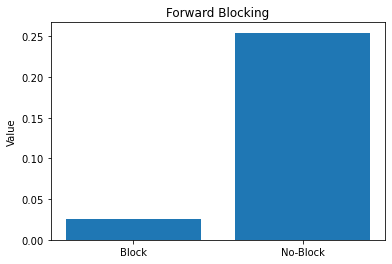

In [5]:
def simulate_forward_blocking():
    """
    Phase 1: A -> +
    Phase 2: AB -> +
    Phase 3: A -> - (only for unblocking  group)
    Test : B -> ?
    """
    control_ktd         = default_kalman_td(2)
    experimental_ktd = default_kalman_td(2)


    # PHASE 1 ==================================================================
    p1_stimulus = np.tile(
        np.array([
            # A -> +
            [[1], [0]],
            [[0], [0]],
        ]),
        [10, 1, 1]
    )
    p1_reward    = np.tile(
        np.array([[0],[1]]),
        [10, 1]
    )

    for i in range(1,len(p1_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )


    # PHASE 2 ==================================================================

    p2_stimulus = np.tile(
        np.array([
            # AB -> +
            [[1], [1]],
            [[0], [0]],
        ]),
        [10,1,1]
    )
    p2_reward    = np.tile(
        np.array([[0],[1]]),
        [10,1]
    )

    for i in range(1,len(p2_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )

            ctrl_expected_reward = predict_reward(
                control_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )

    # PHASE 3 ==================================================================
    p3_stimulus = np.tile(
        np.array([
            # A -> -
            [[1], [0]],
            [[0], [0]],
        ]),
        [10, 1, 1]
    )
    p3_reward    = np.tile(
        np.array([[0],[0]]),
        [10, 1]
    )

    for i in range(1,len(p1_reward)-2,2):
        for j in range(i, i+2):
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p3_stimulus[j],
                p3_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p3_reward[j],
                p3_stimulus[j],
                p3_stimulus[j-1]
            )


    # TEST: B -> ? =============================================================
    test_stimulus = np.array([
        [[0], [1]],
        [[0], [0]],
    ])
    exp_test_reward = predict_reward(
        experimental_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )
    ctrl_test_reward = predict_reward(
        control_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )

    plt.clf()
    barplot = plt.bar([1,2], [exp_test_reward, ctrl_test_reward])
    plt.xticks([1,2], ["Block", "No-Block"])
    plt.ylabel("Value")
    plt.title("Forward Blocking")
    plt.savefig("plots/forward_blocking.svg")

    # return experimental_ktd, control_ktd
    return exp_test_reward, ctrl_test_reward

simulate_forward_blocking()

## Overexpectation

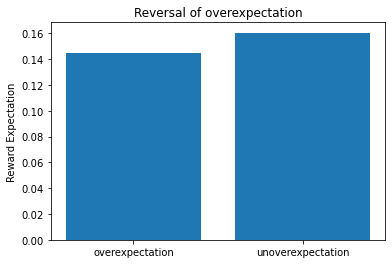

In [6]:
def simulate_overexpectation():
    control_ktd = default_kalman_td(2)
    experimental_ktd = default_kalman_td(2)
    # A -> + / B -> +
    p1_stimulus = np.tile(np.array([
        [[1],[0]],
        [[0],[0]],
        [[0],[1]],
        [[0],[0]]
    ]),[10,1,1])
    p1_reward = np.tile(np.array([[0],[1],[0],[1]]),[10,1])

    for i in range(1,len(p1_reward)-4,4):
        for j in range(i, i+4):
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )

            exp_expected_reward = predict_reward(
                experimental_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )

    # AB -> +
    p2_stimulus = np.tile(np.array([[[1],[1]],[[0],[0]]]),[10,1,1])
    p2_reward = np.tile(np.array([[0],[1]]),[10,1,1])

    for i in range(1,len(p2_reward)-2,2):
        for j in range(i, i+2):
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )

            exp_expected_reward = predict_reward(
                experimental_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )

    # A -> - [only experimental condition]
    p3_stimulus = np.tile(np.array([[[1],[0]],[[0],[0]]]),[10,1,1])
    p3_reward = np.tile(np.array([[0],[0]]),[10,1])

    for i in range(1,len(p3_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p3_stimulus[j],
                p3_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p3_reward[j],
                p3_stimulus[j],
                p3_stimulus[j-1]
            )

    test_stimulus = np.array([[[0],[1]],[[0],[0]]])
    ctrl_test_reward = predict_reward(control_ktd,test_stimulus[1],test_stimulus[0])
    exp_test_reward = predict_reward(experimental_ktd,test_stimulus[1],test_stimulus[0])

    plt.clf()
    barplot = plt.bar([1,2], [ctrl_test_reward, exp_test_reward])
    plt.xticks([1,2], ["overexpectation", "unoverexpectation"])
    plt.ylabel("Reward Expectation")
    plt.title("Reversal of overexpectation")
    plt.savefig("plots/overexpectation.svg")

simulate_overexpectation()

## Conditioned Inhibition

(-0.44433297053563175, -0.21505447993023494)

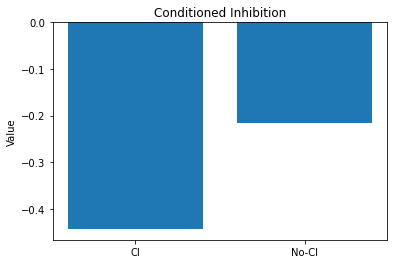

In [7]:
def conditioned_inhibition():
    """
    Phase 1: A -> +
    Phase 2: AB -> -
    Phase 3: A -> - (only uninhibition group)
    Test : B -> ?
    """
    control_ktd         = default_kalman_td(2)
    experimental_ktd = default_kalman_td(2)


    # PHASE 1 ==================================================================
    p1_stimulus = np.tile(
        np.array([
            # A -> +
            [[1], [0]],
            [[0], [0]],
        ]),
        [10, 1, 1]
    )
    p1_reward    = np.tile(
        np.array([[0],[1]]),
        [10, 1]
    )

    preex_posterior_variance, preex_kalman_gain = [], []

    for i in range(0,len(p1_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )

            ctrl_expected_reward = predict_reward(
                control_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )

            preex_posterior_variance.append(
                experimental_ktd.weights_cov[0][0]
            )
            preex_kalman_gain.append(
                experimental_ktd.old_kalman_gain[0]
            )
            # print(experimental_ktd.weights_cov[0][1])

    plt.clf()
    plt.plot(np.arange(1,len(p1_reward)//2), preex_posterior_variance[::2])
    plt.xlabel("Conditioning Trial")
    plt.ylabel("Posterior Variance (A)")
    plt.title("Conditioned Inhibition")
    plt.savefig("plots/conditioned_inhibition_variance_a.svg")

    plt.clf()
    plt.plot(np.arange(1,len(p1_reward)//2), preex_kalman_gain[::2])
    plt.xlabel("Conditioning Trial")
    plt.ylabel("Kalman Gain (A)")
    plt.title("Conditioned Inhibition")
    plt.savefig("plots/conditioned_inhibition_kalman_gain_a.svg")

    # print(experimental_ktd.weights_cov, control_ktd.weights_cov)

    # PHASE 2 ==================================================================

    p2_stimulus = np.tile(
        np.array([
            # AB -> -
            [[1], [1]],
            [[0], [0]],
        ]),
        [10,1,1]
    )
    p2_reward    = np.tile(
        np.array([[0],[0]]),
        [10,1]
    )

    # print(p2_stimulus, p2_reward)

    for i in range(0,len(p2_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )

            ctrl_expected_reward = predict_reward(
                control_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )

    # PHASE 3 ==================================================================
    p3_stimulus = np.tile(
        np.array([
            # A -> -
            [[1], [0]],
            [[0], [0]],
        ]),
        [10, 1, 1]
    )
    p3_reward    = np.tile(
        np.array([[0],[0]]),
        [10, 1]
    )

    for i in range(1,20):
        ctrl_expected_reward = predict_reward(
            control_ktd,
            p3_stimulus[i],
            p3_stimulus[i-1]
        )
        update(
            control_ktd,
            ctrl_expected_reward,
            p3_reward[i],
            p3_stimulus[i],
            p3_stimulus[i-1]
        )

    # TEST: B -> ? =============================================================
    test_stimulus = np.array([
        [[0], [1]],
        [[0], [0]],
    ])
    exp_test_reward = predict_reward(
        experimental_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )
    ctrl_test_reward = predict_reward(
        control_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )

    plt.clf()
    barplot = plt.bar([1,2], [exp_test_reward, ctrl_test_reward])
    plt.xticks([1,2], ["CI", "No-CI"])
    plt.ylabel("Value")
    plt.title("Conditioned Inhibition")
    plt.savefig("plots/conditioned_inhibition.svg")

    # return experimental_ktd, control_ktd
    return exp_test_reward, ctrl_test_reward

conditioned_inhibition()

## Second Order Extinction

(0.09933328871732965, 0.12639653954001834)

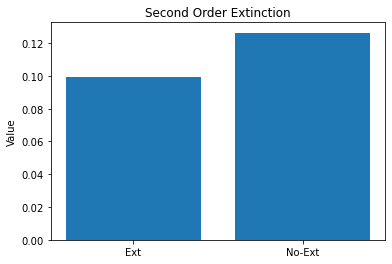

In [13]:
def simulate_second_order_extinction():
	"""
	Phase 1: Z -> X -> - / X -> +
	Phase 2: X -> - for experimental, none for control
	"""
	control_ktd      = default_kalman_td(2)
	experimental_ktd = default_kalman_td(2)


	# PHASE 1 ==================================================================
	p1_stimulus = np.tile(
		np.array([
			# Z -> X -> -
			[[1], [0]],
			[[0], [1]],
			[[0], [0]],
			# X -> +
			[[0], [1]],
			[[0], [0]],
		]),
		[10,1,1]
	)
	p1_reward   = np.tile(
		np.array([[0],[0],[0],[0],[1]]),
		[10,1]
	)

	# print(p1_stimulus, p1_reward)

	for i in range(1,len(p1_reward)-5,5):
		for j in range(i, i+5):
			exp_expected_reward = predict_reward(
				experimental_ktd,
				p1_stimulus[j],
				p1_stimulus[j-1]
			)
			update(
				experimental_ktd,
				exp_expected_reward,
				p1_reward[j],
				p1_stimulus[j],
				p1_stimulus[j-1]
			)

			ctrl_expected_reward = predict_reward(
				control_ktd,
				p1_stimulus[j],
				p1_stimulus[j-1]
			)
			update(
				control_ktd,
				ctrl_expected_reward,
				p1_reward[j],
				p1_stimulus[j],
				p1_stimulus[j-1]
			)

	# PHASE 2 ==================================================================

	p2_stimulus = np.tile(
		np.array([
			# X -> -
			[[0], [1]],
			[[0], [0]],
		]),
		[10, 1, 1]
	)
	p2_reward   = np.tile(
		np.array([[0],[0]]),
		[10, 1]
	)

	for i in range(1,len(p2_reward)-2,2):
		for j in range(i, i+2):
			exp_expected_reward = predict_reward(
				experimental_ktd,
				p2_stimulus[j],
				p2_stimulus[j-1]
			)
			update(
				experimental_ktd,
				exp_expected_reward,
				p2_reward[j],
				p2_stimulus[j],
				p2_stimulus[j-1]
			)

	test_stimulus = np.array([
		[[1], [0]],
		[[0], [0]],
	])
	exp_test_reward = predict_reward(
		experimental_ktd,
		test_stimulus[1],
		test_stimulus[0]
	)
	ctrl_test_reward = predict_reward(
		control_ktd,
		test_stimulus[1],
		test_stimulus[0]
	)

	barplot = plt.bar([1,2], [exp_test_reward, ctrl_test_reward])
	plt.xticks([1,2], ["Ext", "No-Ext"])
	plt.ylabel("Value")
	plt.title("Second Order Extinction")
	plt.savefig("plots/second_order_extinction.svg")

	return exp_test_reward, ctrl_test_reward

simulate_second_order_extinction()

## Overshadowing and Second Order Conditioning

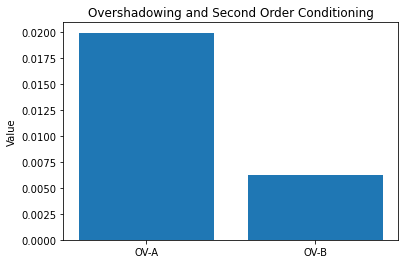

In [8]:
def overshadowing_and_second_order_conditioning():
    # AX->+/BY->+ ; A->- ; Z->X ; Z->?
    # AX->+/BY->+ ; B->- ; Z->X ; Z->?

    # PHASE 1: AX->+/BY->+
    control_ktd         = default_kalman_td(5)
    experimental_ktd = default_kalman_td(5)

    p1_stimulus = np.tile(
        np.array([
            [[1],[1],[0],[0],[0]],
            [[0],[0],[0],[0],[0]],
            [[0],[0],[1],[1],[0]],
            [[0],[0],[0],[0],[0]]
        ]),
        [10,1,1])
    p1_reward    = np.tile(
        np.array([[0],[1],[0],[1]]),
        [10,1]
    )

    p1_cov_ax = []
    p1_kalman_gain_x = []

    for i in range(1,len(p1_reward)-4,4):
        for j in range(i, i+4):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )

            ctrl_expected_reward = predict_reward(
                control_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            p1_cov_ax.append(experimental_ktd.weights_cov[0,1])
            p1_kalman_gain_x.append(experimental_ktd.old_kalman_gain[1])

    plt.clf()
    plt.plot(np.arange(1,len(p1_reward)//4), p1_cov_ax[::4])
    plt.xlabel("Phase 1 trial")
    plt.ylabel("Posterior Covariance (AX)")
    plt.title("Overshadowing and Second Order Conditioning")
    plt.savefig("plots/overshadowing_and_second_order_conditioning_p1_cov_ax.svg")

    plt.clf()
    plt.plot(np.arange(1,len(p1_reward)//4), p1_kalman_gain_x[::4])
    plt.xlabel("Phase 1 trial")
    plt.ylabel("Kalman Gain (X)")
    plt.title("Overshadowing and Second Order Conditioning")
    plt.savefig("plots/overshadowing_and_second_order_conditioning_p1_kalman_gain_x.svg")


    # PHASE 2: A->-[OVA]; B->-[OVB]
    # A->-
    p2a_stimulus = np.tile(
        np.array([
            [[1],[0],[0],[0],[0]],
            [[0],[0],[0],[0],[0]]
        ]),
        [10,1,1])
    p2a_reward    = np.tile(
        np.array([[0],[0]]),
        [10,1]
    )

    p2_cov_ax = []
    p2_kalman_gain_x_ctrl = []


    for i in range(1,len(p2a_reward)-2,2):
        for j in range(i, i+2):
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p2a_stimulus[j],
                p2a_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p2a_reward[j],
                p2a_stimulus[j],
                p2a_stimulus[j-1]
            )
            p2_cov_ax.append(control_ktd.weights_cov[0,1])
            p2_kalman_gain_x_ctrl.append(control_ktd.old_kalman_gain[1])

    # B->-

    p2_kalman_gain_x_expt = []

    p2b_stimulus = np.tile(
        np.array([
            [[0],[0],[1],[0],[0]],
            [[0],[0],[0],[0],[0]]
        ]),
        [10,1,1])
    p2b_reward    = np.tile(
        np.array([[0],[0]]),
        [10,1]
    )

    for i in range(1,len(p2b_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p2b_stimulus[j],
                p2b_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p2b_reward[j],
                p2b_stimulus[j],
                p2b_stimulus[j-1]
            )
            p2_kalman_gain_x_expt.append(control_ktd.old_kalman_gain[1])

    plt.clf()
    plt.plot(np.arange(1,len(p2a_reward)//2), p2_cov_ax[::2])
    plt.xlabel("Phase 2 trial")
    plt.ylabel("Posterior Covariance (AX)")
    plt.title("Overshadowing and Second Order Conditioning")
    plt.savefig("plots/overshadowing_and_second_order_conditioning_p2_cov_ax.svg")

    plt.clf()
    plt.plot(np.arange(1,len(p2a_reward)//2), p2_kalman_gain_x_ctrl[::2], label="OV-A")
    plt.plot(np.arange(1,len(p2b_reward)//2), p2_kalman_gain_x_expt[::2], label="OV-B")
    plt.xlabel("Phase 2 trial")
    plt.ylabel("Kalman Gain (X)")
    plt.title("Overshadowing and Second Order Conditioning")
    plt.legend()
    plt.savefig("plots/overshadowing_and_second_order_conditioning_p2_kalman_gain_x.svg")

    # Phase 3: z -> x
    p3_stimulus = np.tile(
        np.array([
            [[0],[0],[0],[0],[1]],
            [[0],[1],[0],[0],[0]],
            [[0],[0],[0],[0],[0]]
        ]),
        [10,1,1])
    p3_reward    = np.tile(
        np.array([[0],[0],[0]]),
        [10,1]
    )

    for i in range(1,len(p3_reward)-3,3):
        for j in range(i, i+3):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p3_stimulus[j],
                p3_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p3_reward[j],
                p3_stimulus[j],
                p3_stimulus[j-1]
            )

            ctrl_expected_reward = predict_reward(
                control_ktd,
                p3_stimulus[j],
                p3_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p3_reward[j],
                p3_stimulus[j],
                p3_stimulus[j-1]
            )

    test_stimulus = np.array([
        [[0],[0],[0],[0],[1]],
        [[0],[0],[0],[0],[0]]
    ])

    exp_test_reward = predict_reward(
        experimental_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )
    ctrl_test_reward = predict_reward(
        control_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )
    # print(exp_test_reward,ctrl_test_reward)

    plt.clf()
    barplot = plt.bar([1,2], [ctrl_test_reward, exp_test_reward])
    plt.xticks([1,2], ["OV-A", "OV-B"])
    plt.ylabel("Value")
    plt.title("Overshadowing and Second Order Conditioning")
    plt.savefig("plots/overshadowing_and_second_order_conditioning.svg")

overshadowing_and_second_order_conditioning()

## Serial Compound Extinction

(0.19155901375157677, 0.28788054570078503)

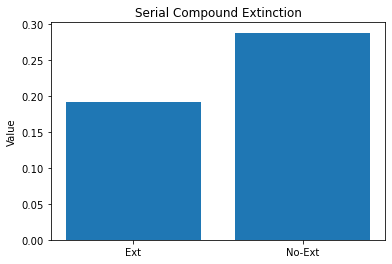

In [10]:
def simulate_serial_compound_extinction():
    """
    Phase 1: Z -> X -> +
    Phase 2: X -> - (only for extinction group)
    Test : Z -> ?
    """
    control_ktd         = default_kalman_td(2)
    experimental_ktd = default_kalman_td(2)


    # PHASE 1 ==================================================================
    p1_stimulus = np.tile(
        np.array([
            # Z -> X -> +
            [[1], [0]],
            [[0], [1]],
            [[0], [0]],
        ]),
        [10, 1, 1]
    )
    p1_reward    = np.tile(
        np.array([[0],[0],[1]]),
        [10, 1]
    )

    preex_posterior_variance, preex_kalman_gain = [0], []

    for i in range(1,len(p1_reward)-3,3):
        for j in range(i, i+3):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p1_stimulus[j],
                p1_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p1_reward[j],
                p1_stimulus[j],
                p1_stimulus[j-1]
            )

            preex_posterior_variance.append(
                experimental_ktd.weights_cov[0,1]
            )
            preex_kalman_gain.append(
                experimental_ktd.old_kalman_gain[1]
            )

    plt.clf()
    plt.plot(np.arange(1,(len(p1_reward)//3)+1), preex_posterior_variance[::3])
    plt.xlabel("Compound Trial")
    plt.ylabel("Posterior CoVariance (ZX)")
    plt.title("Serial Compound Extinction")
    plt.savefig("plots/serial_compound_extinction_covariance_zx.svg")

    # PHASE 2 ==================================================================

    p2_stimulus = np.tile(
        np.array([
            # X -> -
            [[0], [1]],
            [[0], [0]],
        ]),
        [10,1,1]
    )
    p2_reward    = np.tile(
        np.array([[0],[0]]),
        [10,1]
    )


    for i in range(1,len(p2_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )


    # TEST: Z -> ? =============================================================
    test_stimulus = np.array([
        [[1], [0]],
        [[0], [0]],
    ])
    exp_test_reward = predict_reward(
        experimental_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )
    ctrl_test_reward = predict_reward(
        control_ktd,
        test_stimulus[1],
        test_stimulus[0]
    )

    plt.clf()
    barplot = plt.bar([1,2], [exp_test_reward, ctrl_test_reward])
    plt.xticks([1,2], ["Ext", "No-Ext"])
    plt.ylabel("Value")
    plt.title("Serial Compound Extinction")
    plt.savefig("plots/serial_compound_extinction.svg")

    return exp_test_reward, ctrl_test_reward

simulate_serial_compound_extinction()

## Recovery from Overshadowing

(0.6096672731502103, 0.653175864804175)

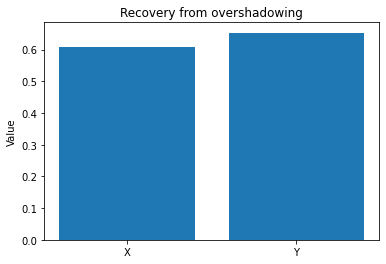

In [11]:
def simulate_recovery_from_overshadowing():
    control_ktd      = default_kalman_td(4)
    experimental_ktd = default_kalman_td(4)

    # Phase 1: Z -> X -> + for experiment; B -> Y -> + for control

    p1e_stimulus = np.tile(
        np.array([
            [[1],[0],[0],[0]],
            [[0],[1],[0],[0]],
            [[0],[0],[0],[0]],
        ]),
        [10,1,1]
    )
    p1e_reward   = np.tile(np.array([[0],[0],[1]]),[10,1])

    p1c_stimulus = np.tile(
        np.array([
            [[0],[0],[1],[0]],
            [[0],[0],[0],[1]],
            [[0],[0],[0],[0]],
        ]),
        [10,1,1]
    )
    p1c_reward   = np.tile(np.array([[0],[0],[1]]),[10,1])

    for i in range(1,len(p1e_reward)-3,3):
        for j in range(i, i+3):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p1e_stimulus[j],
                p1e_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p1e_reward[j],
                p1e_stimulus[j],
                p1e_stimulus[j-1]
            )
            ctrl_expected_reward = predict_reward(
                control_ktd,
                p1c_stimulus[j],
                p1c_stimulus[j-1]
            )
            update(
                control_ktd,
                ctrl_expected_reward,
                p1c_reward[j],
                p1c_stimulus[j],
                p1c_stimulus[j-1]
            )

    # Phase 2: Z -> - for experimental
    p2_stimulus = np.tile(
        np.array([
            [[1],[0],[0],[0]],
            [[0],[0],[0],[0]]
        ]),
        [10,1,1]
    )
    p2_reward = np.tile(np.array([[0],[0]]),[10,1])

    for i in range(1,len(p2_reward)-2,2):
        for j in range(i, i+2):
            exp_expected_reward = predict_reward(
                experimental_ktd,
                p2_stimulus[j],
                p2_stimulus[j-1]
            )
            update(
                experimental_ktd,
                exp_expected_reward,
                p2_reward[j],
                p2_stimulus[j],
                p2_stimulus[j-1]
            )

    # X -> ?
    expt_test_stimulus = np.array([
        [[0],[1],[0],[0]],
        [[0],[0],[0],[0]]
    ])
    # Y -> ?
    ctrl_test_stimulus = np.array([
        [[0],[0],[0],[1]],
        [[0],[0],[0],[0]]
    ])
    exp_test_reward = predict_reward(
        experimental_ktd,
        expt_test_stimulus[1],
        expt_test_stimulus[0]
    )
    ctrl_test_reward = predict_reward(
        control_ktd,
        ctrl_test_stimulus[1],
        ctrl_test_stimulus[0]
    )

    plt.clf()
    barplot = plt.bar([1,2], [exp_test_reward, ctrl_test_reward])
    plt.xticks([1,2], ["X", "Y"])
    plt.ylabel("Value")
    plt.title("Recovery from overshadowing")
    plt.savefig("plots/recovery_from_overshadowing.svg")

    return exp_test_reward, ctrl_test_reward

simulate_recovery_from_overshadowing()